In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr  # IF NECESSARY, from terminal: pip install pandas_datareader
import seaborn as sns
from numpy.random import default_rng

# these three are used to open the CCM dataset:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

pd.set_option("display.max_rows", 10)  # display option for pandas

# Plotting

We will plot with 3 datasets this week. Let's load them. 

In [2]:
# LOAD DATA AND CONVERT TO ANNUAL

start = 1990 # pandas datareader can infer these are years
end = 2018
macro_data = pdr.data.DataReader(['CAUR','MIUR','PAUR', # unemployment 
                                  'LXXRSA','DEXRSA','WDXRSA', # case shiller index in LA, Detroit, DC (no PA  available!)
                                  'MEHOINUSCAA672N','MEHOINUSMIA672N','MEHOINUSPAA672N'], #  
                                 'fred', start, end)
macro_data = macro_data.resample('YE').first() # get's the first observation for each variable in a given year

# CLEAN UP THE FORMATING SOMEWHAT

macro_data.index = macro_data.index.year
macro_data.columns=pd.MultiIndex.from_tuples([
    ('Unemployment','CA'),('Unemployment','MI'),('Unemployment','PA'),
    ('HouseIdx','CA'),('HouseIdx','MI'),('HouseIdx','PA'),
    ('MedIncome','CA'),('MedIncome','MI'),('MedIncome','PA')
    ])



In [3]:
year_state_tall = macro_data.stack().reset_index().rename(columns={'level_1':'state'}).sort_values(['state','DATE'])    

year_state_wide = macro_data
# one level names
year_state_wide.columns=[
    'Unemployment_CA','Unemployment_MI','Unemployment_PA',
    'HouseIdx_CA','HouseIdx_MI','HouseIdx_PA',
    'MedIncome_CA','MedIncome_MI','MedIncome_PA'
    ]

/var/folders/0w/sth8nzm513v609lmyg7vsnfc0000gn/T/ipykernel_5976/3068843673.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  year_state_tall = macro_data.stack().reset_index().rename(columns={'level_1':'state'}).sort_values(['state','DATE'])


## And load CCM data

First, load the data

In [4]:
url = 'https://github.com/LeDataSciFi/ledatascifi-2025/blob/main/data/CCM_cleaned_for_class.zip?raw=true'

#firms = pd.read_stata(url)   
# <-- that code would work, but GH said it was too big and
# forced me to zip it, so here is the work around to download it:

with urlopen(url) as request:
    data = BytesIO(request.read())

with ZipFile(data) as archive:
    with archive.open(archive.namelist()[0]) as stata:
        ccm = pd.read_stata(stata)

## Sidebar: Here's a fun EDA hack:

https://ydata-profiling.ydata.ai/docs/master/index.html

Notes
- Slow with huge datasets (see webpage 
- Doesn't work with multiindex column names (must be "one level")

In [5]:
# install new package (run this one time only)
# !pip install -U ydata-profiling

# i got an error towards the end but it still installed...

In [6]:
# this package used to be called pandas-profiling
# new name, better performance (speed and features)
# from ydata_profiling import ProfileReport

# create the report:
# profile = ProfileReport(macro_data, title="Pandas Profiling Report")
# profile.to_file("macro_data_report.html")



From the `year_state` data (wide or tall):

_("unemployment changes": Focus on the change in the _level_ (raw difference, not percent change) of unemployment from one year compared the prior year.)_

- Q0. How has median income has evolved over time for PA?
    - Demos...
- Q1. How has *unemployment changes* evolved over time for PA?   
- Q2. What is the distribution of unemployment changes for all states (view as one var)?   
- Q3. What is the distribution of unemployment changes for all states (separately)?
- Q4. How does unemployment changes vary with median income growth?

From the `ccm` data:

- Q5. Plot the distribution of R&D (`xrd_a`). Bonuses:
    - deal with outliers
    - add a title
    - change the x and y axis titles
- Q6: Compare R&D and CAPX. Bonuses:
    - don't plot outliers
    - avoid oversaturated plot

<Axes: xlabel='DATE'>

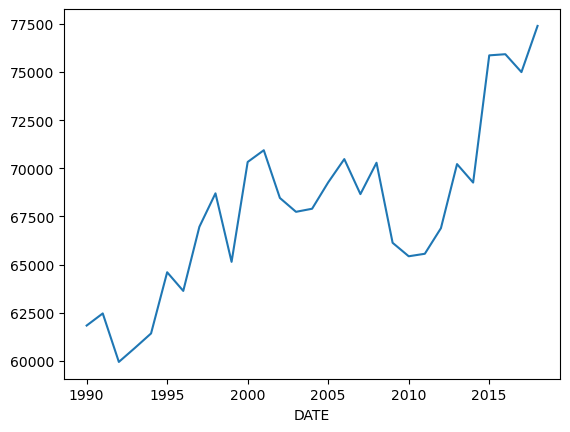

In [7]:
year_state_wide['MedIncome_PA'].plot()

<Axes: xlabel='DATE', ylabel='MedIncome_PA'>

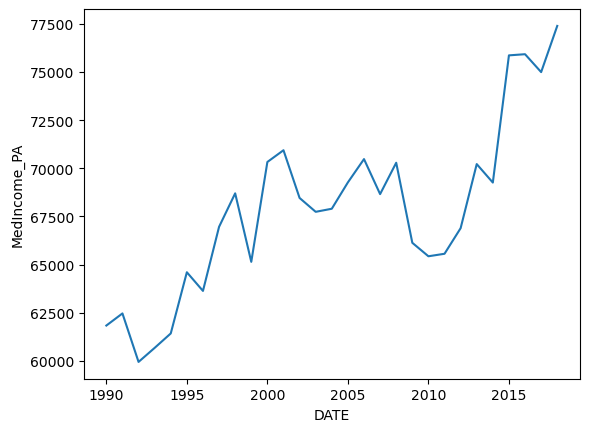

In [8]:
#seaborn
sns.lineplot(data=year_state_wide,
             x= 'DATE',
             y= 'MedIncome_PA'
            )
             

In [9]:
year_state_tall

,DATE,state,Unemployment,HouseIdx,MedIncome
0,1990,CA,5.2,100.471193,70960.0
3,1991,CA,7.1,95.569015,69240.0
6,1992,CA,8.6,92.786926,70010.0
9,1993,CA,9.8,85.246295,66700.0
12,1994,CA,9.3,77.395052,67680.0
...,...,...,...,...,...
74,2014,PA,6.5,206.966200,69260.0
77,2015,PA,5.5,208.705043,75870.0
80,2016,PA,5.3,212.104879,75930.0
83,2017,PA,5.2,218.251827,75000.0


<Axes: xlabel='DATE', ylabel='MedIncome'>

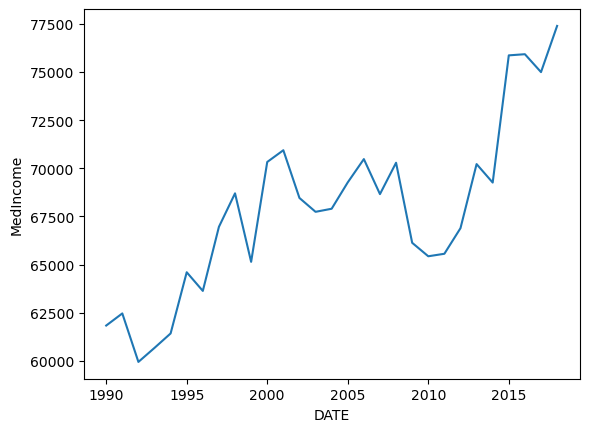

In [10]:
#
sns.lineplot(data=year_state_tall.query('state == "PA"'),
             x= 'DATE',
             y= 'MedIncome'
            )

## Q1 - How has unemployment changed in PA overtime?

<Axes: xlabel='DATE'>

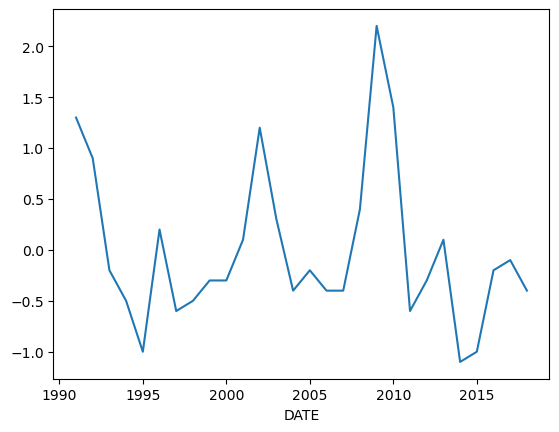

In [11]:
year_state_wide['Unemployment_PA'].diff().plot()



In [15]:
#year_state_tall['Unemployment_diff'] = year_state_tall['Unemployment'].diff() WRONG

year_state_tall['diff'] = year_state_tall.groupby('state')['Unemployment'].diff()
year_state_tall[24:34]

,DATE,state,Unemployment,HouseIdx,MedIncome,Unemployment_diff,diff
72,2014,CA,8.2,216.572242,75930.0,-1.5,-1.5
75,2015,CA,6.8,228.251741,79940.0,-1.4,-1.4
78,2016,CA,5.7,243.465406,82980.0,-1.1,-1.1
81,2017,CA,5.2,256.220008,85710.0,-0.5,-0.5
84,2018,CA,4.4,275.208248,84560.0,-0.8,-0.8
1,1990,MI,7.7,NaN,63810.0,3.3,NaN
4,1991,MI,8.8,58.420806,66060.0,1.1,1.1
7,1992,MI,9.5,59.748947,64720.0,0.7,0.7
10,1993,MI,7.6,61.564205,63930.0,-1.9,-1.9
13,1994,MI,7.2,64.526663,67590.0,-0.4,-0.4


<Axes: xlabel='DATE', ylabel='diff'>

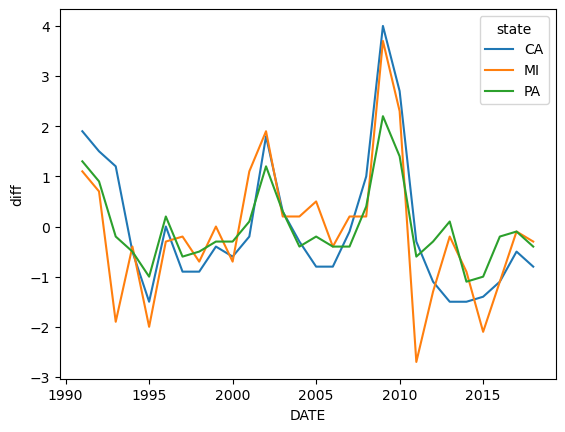

In [18]:
sns.lineplot(data=year_state_tall,
             x = 'DATE',
             y = 'diff',
            hue = 'state')

## Q2

[Text(0.5, 1.0, 'Distribution of Unemployment Changes for All States'),
 Text(0.5, 0, 'Unemployment change'),
 Text(0, 0.5, 'Values')]

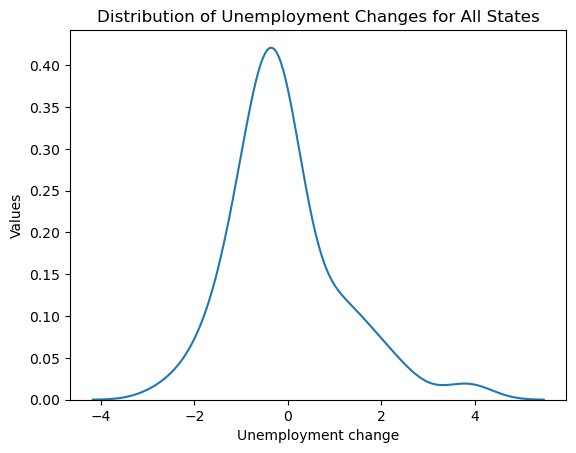

In [30]:
sns.kdeplot(year_state_tall['diff']).set(title="Distribution of Unemployment Changes for All States",
            xlabel = "Unemployment change",
            ylabel = "Values")


## Q3

<Axes: xlabel='state', ylabel='diff'>

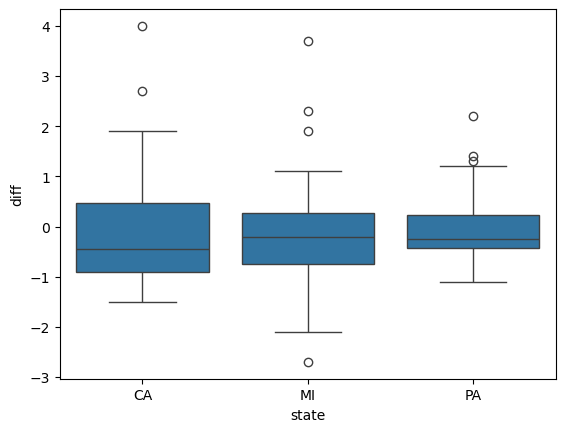

In [32]:
sns.boxplot(x="state", y ="diff", data=year_state_tall)

<Axes: xlabel='state', ylabel='diff'>

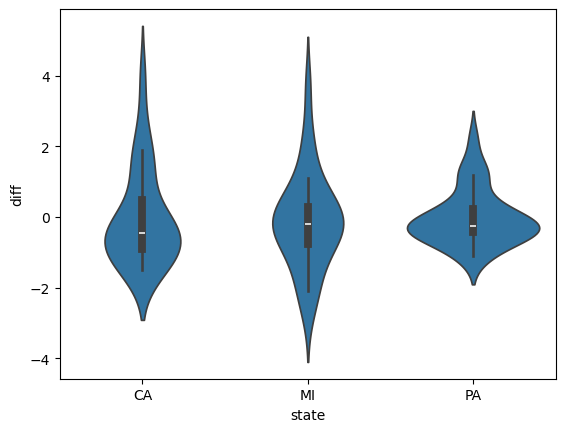

In [38]:
sns.violinplot(x="state", y ="diff", data=year_state_tall)

<Axes: xlabel='diff', ylabel='Density'>

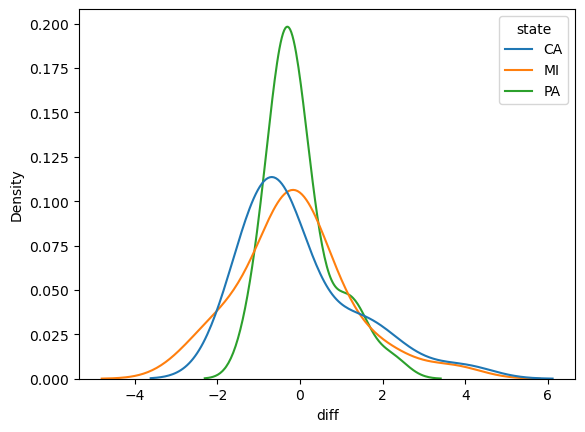

In [37]:
sns.kdeplot(hue="state", x ="diff", data=year_state_tall)

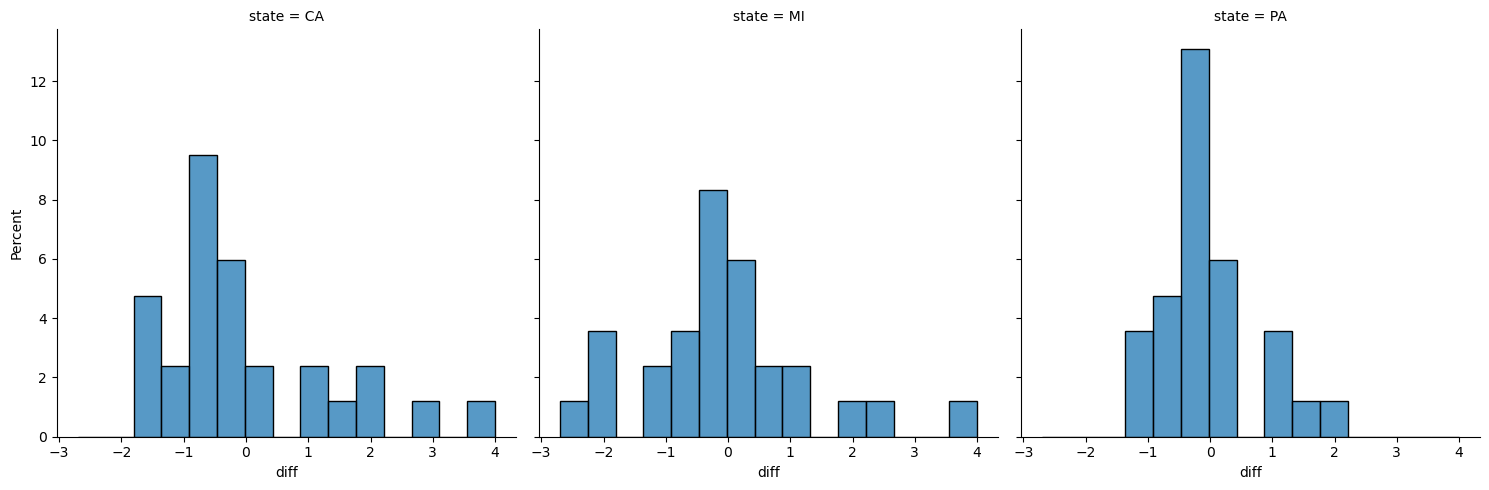

In [40]:
sns.displot(kind = 'hist', col="state", x ="diff", data=year_state_tall, stat = 'percent')

## Q4

In [45]:
year_state_tall['MedIncome_Change'] = year_state_tall.groupby('state')['MedIncome'].pct_change()

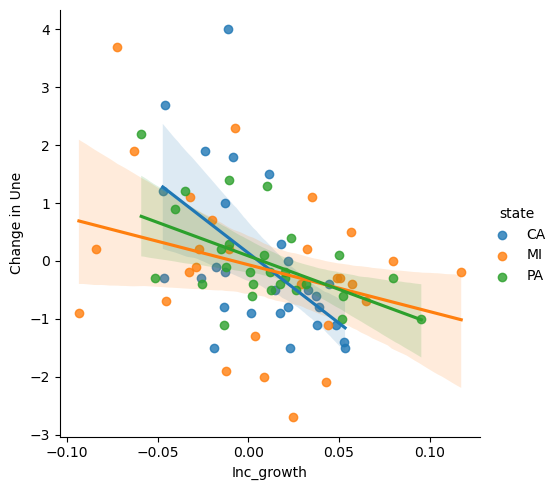

In [49]:
sns.lmplot(x="MedIncome_Change", y='diff', data=year_state_tall, hue = "state").set(
ylabel='Change in Une', xlabel = 'Inc_growth')

## Q5

<Axes: >

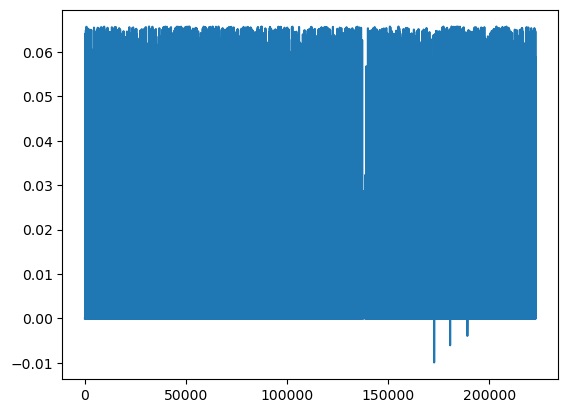

In [53]:
Q1 = ccm['xrd_a'].quantile(.25)
Q3 = ccm['xrd_a'].quantile(.75)
IQR = Q3-Q1

lower_bound = Q1 -1.5*IQR
upper_bound = Q3 +1.5*IQR

xrd_no_outliers=ccm[(ccm['xrd_a'] >= lower_bound)&(ccm['xrd_a'] <= upper_bound)]

xrd_no_outliers['xrd_a'].plot()

In [ ]:
#sns.displot(data=ccm.query('xrd_a >= 0 & xrd_a < .25')[:1000], kde=False)

<Axes: xlabel='xrd_a', ylabel='capx_a'>

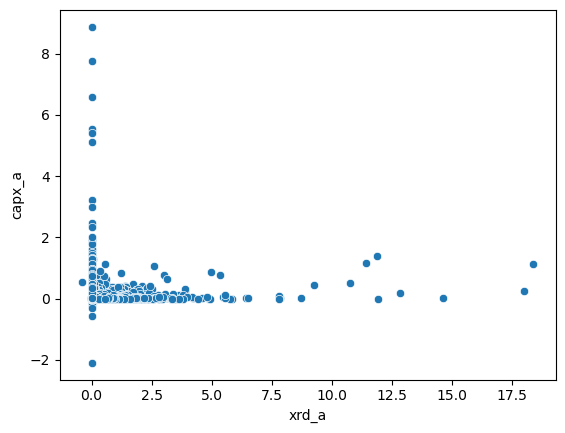

In [60]:
sns.scatterplot(data = ccm, x='xrd_a', y = 'capx_a')
